# Import

In [16]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('once')
warnings.filterwarnings("ignore", category=DeprecationWarning)
import os
import numpy as np
import pandas as pd
from datetime import datetime
import hdf5storage

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Params

In [6]:
# data directory
data_dir = '/Users/trevormcpherson/Desktop/Voytek/Organoids/organoidData/CTC/'
#'/Users/blancamartin/Desktop/Voytek_Lab/timescales/organoid_data/CTC_data/'
# file type, constant, for each recording there is a directory that is the name of the recording, and then this file name within it
file_type = 'LFP_Sp.mat'
# all recording folders have this string in their name
recording_string = 'CTC'
# get recording directories
recording_directories = os.listdir(data_dir)
# only keep recoring directories
recording_directories = [s for s in recording_directories if recording_string in s]
# number of recordings
n_recordings = len(recording_directories)
# total number of wells
total_n_wells = 12
# no data in first 4 wells, if not specifying specific ones to analyze, skip these first 4
wells_to_skip = 4
# number of wells
n_wells = total_n_wells - wells_to_skip
# number of channels
n_channels = 64
# spike recording sample rate
spike_sample_rate = 12500 # samp per sec
# length of time bins using to separate spikes (seconds)
bin_length = 0.05
# bin length in ms
bin_length_ms = int(bin_length * 1000)
# param for determining network spiking events, floor division of the maximum spikes found in a bin by this number
max_spike_floor_division = 2
# analysis window kernel (seconds, total of 3)
kernel_window_sec = [-0.5,2.5]
# length of kernel window
kernel_window_length = np.abs(kernel_window_sec[0]) + kernel_window_sec[1]
# convert to bins
kernel_window_idx = np.divide(kernel_window_sec,bin_length).astype(int)
num_bins_kernel = np.abs(kernel_window_idx[0]) + kernel_window_idx[1]
# get sequential times of bins in kernel
kernel_times = np.linspace(0,kernel_window_length,num_bins_kernel)
#day fo organoid differentation as a time object
day_diff = datetime.strptime("011917",'%m%d%y')

In [7]:
def get_dpdf(time_object, day_diff):
    """ Converts data time object into days post differentiation int value"""
    duration = time_object - day_diff         
    duration_in_s = duration.total_seconds() 
    #days post differentiation in days
    days  = duration.days                        
    dpdf  = int(divmod(duration_in_s, 86400)[0] )      # Seconds in a day = 86400
    
    return dpdf

def bin_spikes(spike_times, bin_size, bins_per_window=None, fs=20000):
    
    # Convert from ms to samples
    bin_size = round((bin_size / 1000) * fs)
    samples = (spike_times / 1000 * fs).astype(int)

    # Init spike counts
    spikes = np.zeros(samples[-1] // bin_size, dtype=int)
    # Bin spikes
    bin_ind = 0
    for i in samples:
        bin_ind = i // bin_size
        if bin_ind > len(spikes)-1:
            break
        spikes[bin_ind] += 1
        
    # Create windows from binned counts
    if bins_per_window is not None:
        max_bin = int((len(spikes) // bins_per_window) * bins_per_window)
        spikes = spikes[:max_bin]
        spikes = spikes.reshape(-1, bins_per_window)
        
    return spikes

# Step 1: Collect meta data

In [8]:
# metadata column labels
metadata_column_labels = ['recording','day_postdiff','well','channel']
# initialise metadata dataframe
organoid_metadata = pd.DataFrame(columns=metadata_column_labels, dtype=object)

# loop through recordings
for this_recording_directory in recording_directories:
    # get date string
    date_string = this_recording_directory[4:10]
    
    # convert to date time object
    date_object = datetime.strptime(date_string,'%m%d%y')
    
    #convert data time object to days post differentiation
    dfdf = get_dpdf(date_object, day_diff)

    # loop through wells
    for well_i in range(n_wells):
        # loop through channels
        for channel_i in range(n_channels):
            # build row for matadata dataframe
            df_row_list = [date_object, dfdf ,well_i,channel_i]
            df_row = pd.DataFrame([df_row_list], columns=metadata_column_labels)
            # add row to dataframe
            organoid_metadata = pd.concat([organoid_metadata, df_row])

In [9]:
organoid_metadata.head()

,recording,day_postdiff,well,channel
0,2016-12-06,-44,0,0
0,2016-12-06,-44,0,1
0,2016-12-06,-44,0,2
0,2016-12-06,-44,0,3
0,2016-12-06,-44,0,4


# Step 2: # Get network events kernels

In [10]:
# initialize list for storing network event kernels for each recording
network_event_kernels_all_recordings = []
# initialize list for storing kernel bins for each recording
kernel_bins_all_recordings = []
# loop through recordings
for this_recording_directory in recording_directories:
    # get mat file path
    mat_file_path = data_dir + this_recording_directory + '/' + file_type
    # load mat file
    data = hdf5storage.loadmat(mat_file_path)
    # get spikes
    spikes = data['spikes']
    # t_s - recording time in seconds
    time_sec = data['t_s']
    # get last time point in recording
    recording_end_time = np.floor(time_sec[-1])
    # number of time bins in this recording
    num_bins_recording = np.floor(recording_end_time / bin_length).astype('int')

    # initialize list for storing network event kernels for each well
    network_event_kernels_all_wells = []
    # initialize list for storing kernel bins for each well
    kernel_bins_all_wells = []
    # loop through wells
    for well_i in range(wells_to_skip,total_n_wells):
        # get spikes for this well
        spikes_well = spikes[well_i]

        # initialzie to store all spike timestamps, and binned spikes for channels
        spike_times = np.array([])
        binned_spikes_all_channels = []
        # loop through channels
        for channel_i in range(n_channels):
            # get spikes for this channel
            spikes_channel = spikes_well[channel_i]
            # only bin if there are spikes
            if spikes_channel.size > 0:
                # get spike time stamps (seconds)
                spike_times_channel = spikes_channel / spike_sample_rate
                # store time stapms for this channel
                spike_times = np.concatenate((spike_times_channel.flatten(), spike_times))
                # binning function uses ms units, convert spike times to ms
                spike_times_channel_ms = spike_times_channel * 1000
                # binned spikes
                binned_spikes_channel = bin_spikes(spike_times_channel_ms,bin_length_ms,fs=spike_sample_rate)
            else:
                binned_spikes_channel = np.array([])
            # store binned spikes for this channel
            binned_spikes_all_channels.append(binned_spikes_channel)

        # binning function uses ms units, convert spike times to ms
        spike_times_ms = spike_times * 1000
        # bin all spikes together
        binned_spikes_all = bin_spikes(spike_times_ms,bin_length_ms,fs=spike_sample_rate)
        # get max number of spikes across all bins
        max_bin_spikes = max(binned_spikes_all)
        # set threshold for detecting large number of spikes
        network_event_thresh = max_bin_spikes // max_spike_floor_division
        # get indexes that are greater than threshold
        net_event_idxs = np.where(binned_spikes_all > network_event_thresh)[0]
        # number of network events
        num_net_events = len(net_event_idxs)

        # initialize list of total kernels we will be collecting - used to ensure there isnt overlap between kernels
        other_kernels = np.zeros((1,2))
        # initialize network events we will be storing
        network_kernels = np.zeros((1,2))
        # initialize and loop through network events
        for event in net_event_idxs:
            # define windows around each event onset
            kernel_start = event + kernel_window_idx[0]
            kernel_stop = event + kernel_window_idx[1]
            # assume we will store this kernel
            store_kernel = 1
            # only store if start and stop are both within the range of bins we have
            if kernel_start < 0 or kernel_stop > num_bins_recording:
                store_kernel = 0
            # only store if there is no overlap with previous kernels
            for previous_kernel in other_kernels:
                if previous_kernel[0] <= kernel_start <= previous_kernel[1] or previous_kernel[0] <= kernel_stop <= previous_kernel[1]:
                    store_kernel = 0
            # only store if mean firing rate is above 0
            net_spikes_this_kernel = binned_spikes_all[kernel_start:kernel_stop]
            mean_spiking_this_kernel = np.sum(net_spikes_this_kernel) / num_bins_kernel
            if mean_spiking_this_kernel <= 0:
                store_kernel = 0
            # store unless one of our conditions is not met
            if store_kernel:
                network_kernels = np.vstack((network_kernels, [kernel_start, kernel_stop])).astype(int)
                # also update total list of kernels
                other_kernels = np.vstack(
                    (other_kernels, [kernel_start, kernel_stop])).astype(int)
        # remove initializing zero row
        network_kernels = network_kernels[1:]
        # number of network kernels
        n_network_kernels = len(network_kernels)
        # store network event kernels for this well
        network_event_kernels_all_wells.append(network_kernels)

        # initialize list for kernels for this well
        kernel_bins_all_channel = []
        # loop through channels
        for channel_i in range(n_channels):
            # get binned spikes for this channel
            binned_spikes_channel = binned_spikes_all_channels[channel_i]
            # initialize list for kernels for this channel
            kernel_bins_all = []
            # loop though network kernels
            for kernel_i in range(n_network_kernels):
                # get kernel start and stop
                kernel_start = network_kernels[kernel_i][0]
                kernel_stop = network_kernels[kernel_i][1]
                # get bins for this kernel
                kernel_bins = binned_spikes_channel[kernel_start:kernel_stop]
                # store kernel for this channel
                kernel_bins_all.append(kernel_bins)
            # store kernels for this well
            kernel_bins_all_channel.append(kernel_bins_all)

        # store kernels for this well
        kernel_bins_all_wells.append(kernel_bins_all_channel)

    # store network event kernels for this recording
    network_event_kernels_all_recordings.append(network_event_kernels_all_wells)
    # store kernel bins for this recording
    kernel_bins_all_recordings.append(kernel_bins_all_wells)

/Users/trevormcpherson/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/trevormcpherson/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


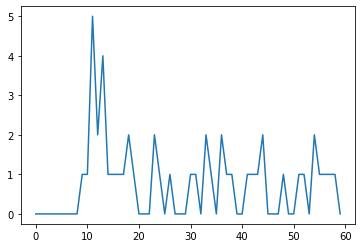

In [20]:
import matplotlib.pyplot as plt
plt.plot(kernel_bins_all_recordings[41][6][34][4])

In [3]:
# Workflow
from ndspflow.workflows import WorkFlow  

ModuleNotFoundError: No module named 'ndspflow'